<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=500 height=300 align=center class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3 - Hunting using Bayes Nets  <br>
<font color=696880 size=4>
Ali Nazari


# Personal Data

In [2]:
student_number = "400104801"
Name = "Mehran"
Last_Name = "Bakhtiari"

<font color="red">
It is highly recommended to do and run the exercise on colab. Otherwise, the graphics display may have problems.
</font>

# Q2: Hunting using Bayes Nets  (100 Points)

# Introduction

In this question, you should assist the bear in locating the deer on the map. The bear is unaware of the specific cell where the deer is located, but each cell contains probabilities and evidence. By leveraging these factors, the bear can make a good guess about the deer's whereabouts. Therefore, your task is to aid the bear in finding its food. As you may know, deer are fond of lettuce, and the presence of lettuce in an area depends on the presence of a warm air mass and Masai giraffes. Warm air can accelerate the growth of lettuce, and Masai giraffes consume lettuce. Additionally, the presence of deer in a location is contingent upon the likelihood of other hunters being present. Ultimately, based on these factors, the bear can estimate the probability of deer presence on each side. The complete graph is like this:

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1sB3zFmmywkVH-0lyp2QzNgqLJLsvKcfm' />
<figcaption>Graph</figcaption></center>
</figure>

All nodes operate in binary mode. For each cell, we will provide you with the graph and CPTs in full detail, and you should determine the direction in which the bear should move. You should initially solve the question using the variable elimination approach. Now, we will outline the format of the graph. For variable elimination, you should complete the "variable_elimination" function. The input of this function will be the input graph, and the output should be "left," "right," "up," or "down". The input is a dictionary, and here is an example of it:

<center>
{"1": {"parents": [ ], "CPT": [0.8]}, ..., "6": {"parents": [3, 4], "CPT": [0.66, 0.52, 0.31, 0.823]}, "observed": {"1": true, "3": true}}
</center>

So, there are 6 keys from 1 to 6, each with "parents" and "CPT". The "parents" key is a list of integers indicating the node's parents. The "CPT" key represents the Conditional Probability Table for each node and its probabilities. For probabilities, we provide only positive conditions, and you can easily infer the negative situations. For nodes with two parents, such as nodes 5 and 6, the first number represents when both parents are positive, the second number when the parent with the lower ID is positive and the parent with the higher ID is negative, the third number when the parent with the lower ID is negative and the parent with the higher ID is positive, and the fourth number when both parents are negative. And finally, we have the "observed" key, which is a dictionary indicating which nodes are observed as evidence and whether they are positive (True) or negative (False).
<br>
It is evident that the query pertains to nodes number 5 and 6. When you obtain the probability of node number 5, you have the probability of moving to the right, and you can easily determine the probability of moving to the left. Similarly, when you acquire the probability of node number 6, you have the probability of moving downward, and again, you can calculate the probability of moving upward.
<br>
<b>
Pay attention that in the end you have 4 probabilities for the 4 main directions and it is guaranteed that none of these 4 numbers will be equal and it is enough to find the max between them and move the bear in the same direction.
</b>

In the next step solve exactly the same problem with the same format of input via prior sampling and rejection sampling approaches (number of samples = 300).

# **Don't Change These Cells**

Upload UtilsAndAssets.zip

In [3]:
!unzip ./UtilsAndAssets.zip

Archive:  ./UtilsAndAssets.zip
  inflating: utils.py                
   creating: images/
  inflating: images/bear.png         
  inflating: images/deer.png         
  inflating: images/giraffe.png      
  inflating: images/hot.png          
  inflating: images/lettuce.png      
  inflating: images/lion.png         
  inflating: images/tiger.png        
  inflating: CPTs.json               


In [4]:
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import os, sys
import pygame
import random
import json
import re
from typing import Dict

random.seed(5)

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [6]:
from utils import *

In [7]:
InputDict = Dict[str, Dict]

# **Variable Elimination (50 Points)**

In [62]:
from typing import List

def variable_elimination(input_graph: InputDict) -> str:
    directions_probabilities = {"left": 0, "right": 0, "up": 0, "down": 0}

    cpts = {}
    for node_id in range(1, 7):
        cpts[node_id] = input_graph.get(str(node_id), {}).get("CPT", [])

    observed = input_graph.get("observed", {})

    def eliminate_one_variable(pb_node: List[float], pb_parent: List[float], observation):
        if observation is None:
            return [pb_parent[0] * pb_node[0] + pb_parent[2] * (1 - pb_node[0]),
                    pb_parent[1] * pb_node[0] + pb_parent[3] * (1 - pb_node[0])]
        elif observation:
            return [pb_parent[0], pb_parent[1]]
        else:
            return [pb_parent[2], pb_parent[3]]

    def eliminate_two_variables(pb_node: List[float], pb_parent: List[float], observation):
        if observation is None:
            return [pb_parent[0] * pb_node[0] + pb_parent[1] * (1 - pb_node[0])]
        elif observation:
            return [pb_parent[0]]
        else:
            return [pb_parent[1]]

    pb_parent_if_node = eliminate_one_variable(cpts[1], cpts[4], observed.get("1"))
    pb_parent = eliminate_two_variables(cpts[2], pb_parent_if_node, observed.get("2"))
    pb_child1_if_parent = eliminate_one_variable(cpts[3], cpts[5], observed.get("3"))
    pb_child2_if_parent = eliminate_one_variable(cpts[3], cpts[6], observed.get("3"))
    pb_child1 = eliminate_two_variables(pb_parent, pb_child1_if_parent, observed.get("4"))
    pb_child2 = eliminate_two_variables(pb_parent, pb_child2_if_parent, observed.get("4"))

    directions_probabilities["right"] = pb_child1[0]
    directions_probabilities["left"] = 1 - pb_child1[0]
    directions_probabilities["down"] = pb_child2[0]
    directions_probabilities["up"] = 1 - pb_child2[0]

    return max(directions_probabilities, key=directions_probabilities.get)

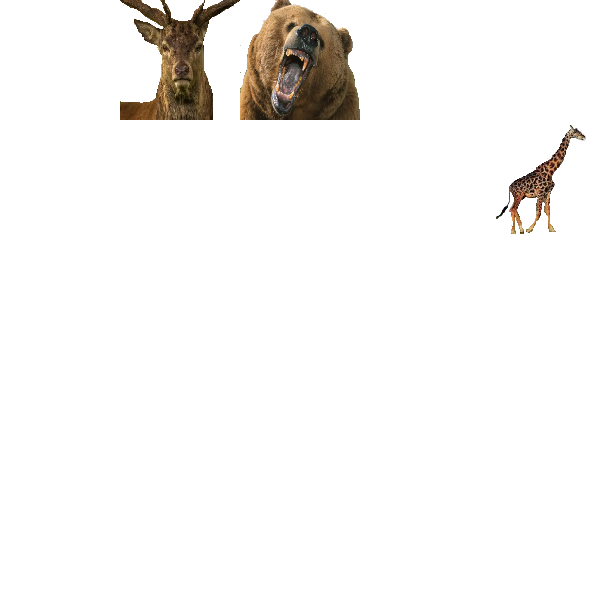

Test PASSED!


In [65]:
play_game(variable_elimination, test1)

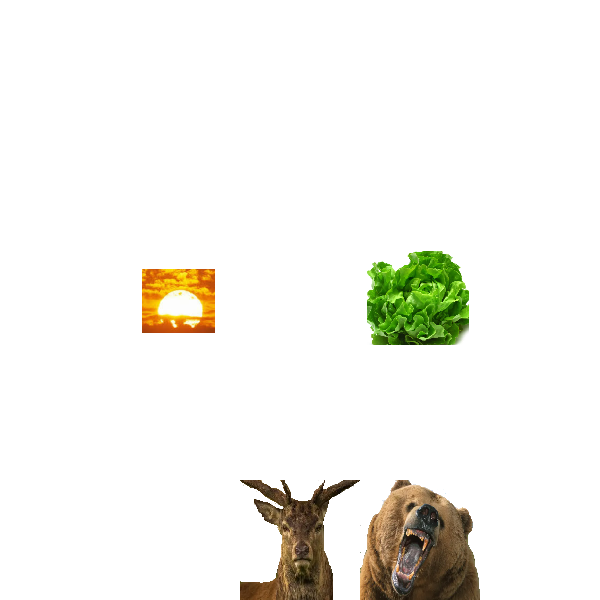

Test PASSED!


In [67]:
play_game(variable_elimination, test2)

# **Prior Sampling (25 Points)**

In [ ]:
import numpy as np

def prior_sampling(input_graph: dict) -> str:
    num_samples = 300
    right_count, down_count = 0, 0

    for _ in range(num_samples):
        sample = {}

        for node, data in input_graph.items():
            if node != "observed":
                cpt = data["CPT"]
                cpt_index = 0

                for parent in data["parents"]:
                    cpt_index = (cpt_index << 1) + (1 - int(sample.get(str(parent), False)))

                sample[node] = np.random.choice([True, False], p=[cpt[cpt_index], 1 - cpt[cpt_index]])

        if sample["5"] == True:
            right_count += 1
        if sample["6"] == True:
            down_count += 1

    down_prob = down_count / num_samples
    right_prob = right_count / num_samples

    return max([(down_prob, 'down'), (1 - down_prob, 'up'), (right_prob, 'right'), (1 - right_prob, 'left')])[1]

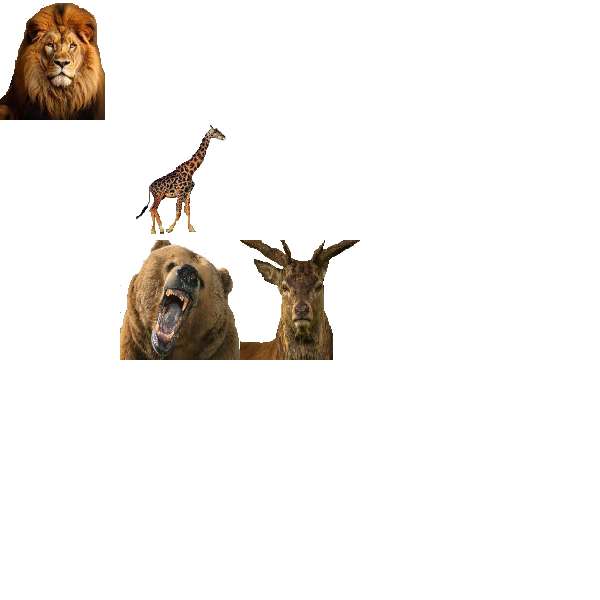

Test PASSED!


In [ ]:
play_game(prior_sampling, test3)

# **Rejection Sampling (25 Points)**

In [ ]:
import numpy as np

def rejection_sampling(input_graph: dict) -> str:
    num_samples = 300
    accepted_samples = 0
    right_count, down_count = 0, 0

    for _ in range(num_samples):
        sample = {}

        for node, data in input_graph.items():
            if node != "observed":
                cpt = data["CPT"]
                cpt_index = 0
                for parent in data["parents"]:
                    cpt_index = (cpt_index << 1) + (1 - int(sample.get(str(parent), False)))
                sample[node] = np.random.choice([True, False], p=[cpt[cpt_index], 1 - cpt[cpt_index]])

        if all(sample.get(var) == value for var, value in input_graph["observed"].items()):
            accepted_samples += 1
            if sample["5"]:
                right_count += 1
            if sample["6"]:
                down_count += 1

    down_prob = down_count / accepted_samples
    right_prob = right_count / accepted_samples

    return max([(down_prob, 'down'), (1 - down_prob, 'up'), (right_prob, 'right'), (1 - right_prob, 'left')])[1]

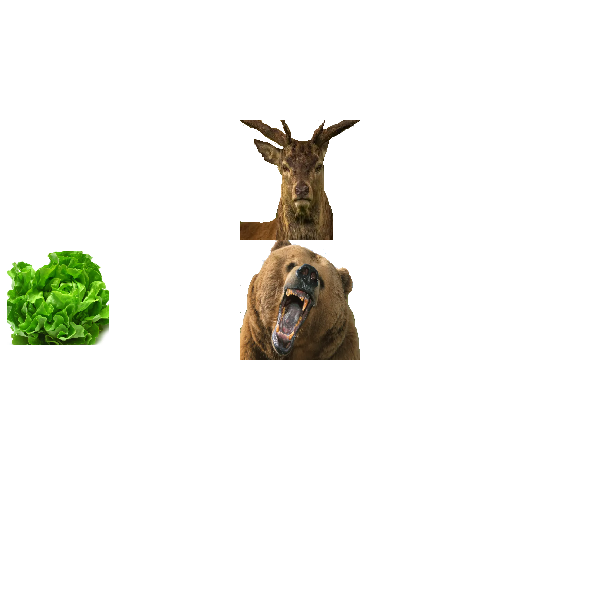

Test PASSED!


In [ ]:
play_game(rejection_sampling, test4)